[View in Colaboratory](https://colab.research.google.com/github/abhiksark/MajorProject/blob/master/cluttered%20code.ipynb)

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import files
uploaded = files.upload()
!pip install -U -q PyDrive ## you will have install for every colab session




In [0]:
!mkdir /content/.kaggle
#!mv /content/.kaggle kaggle.json
#!ls
#!chmod 600 ~ kaggle.json
!mv kaggle.json /content/.kaggle
!ls /content/.kaggle/
!chmod 600 ~ /content/.kaggle/kaggle.json


In [0]:
!pip install kaggle
!kaggle competitions list -s health
!kaggle competitions download -c diabetic-retinopathy-detection -p datalab

In [0]:
!apt-get install p7zip-full

In [0]:
%%capture
!7z x datalab/train.zip.001

In [0]:
!ls train | head -4

In [0]:
"""from google.colab import files
for i in range(11,59):
  try:
    files.download("train/100"+str(int(i))+"_left.jpeg")
    files.download("train/100"+str(int(i))+"_right.jpeg")
  except:
     pass"""

In [0]:
import numpy as np # linear algebra
import pandas as pd 
import os

In [0]:
!unzip datalab/trainLabels.csv.zip

35126

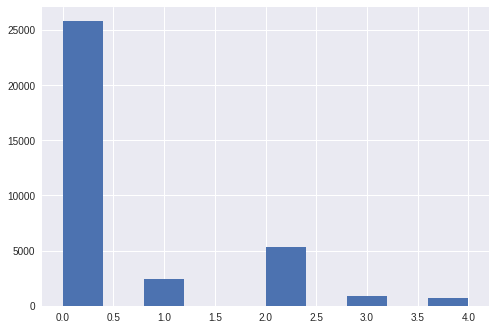

In [4]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()
trainLabels["level"].hist()
trainLabels["level"].unique()
listing = os.listdir("train") 
len(listing)

In [0]:
listing_test=listing[:15000]
listing_val=listing[15000:20000]


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 19 23:09:09 2018

@author: abhik
"""

import cv2 as cv
import numpy as np
import math

# Standard resolution of images after processing.
STD_RES = 756

# Thresholding parameter.
THRESH = 30  # For edge detection

# Canny edge detection parameters.
LOW_THRESH = 0
MAX_THRESH = 255
KERNEL = 3

# Hough Circle Transform parameters.
DP = 2  # Inverse accumulator ratio.
MD = STD_RES  # Minimum distance between circles.
P1 = 140
P2 = 30
MIN_R = int(STD_RES * 0.4)
MAX_R = STD_RES

# Blob detection parameters (for notch detection).
BLOB_PARAMS = cv.SimpleBlobDetector_Params()
BLOB_PARAMS.minThreshold = 0.0
BLOB_PARAMS.maxThreshold = THRESH
BLOB_PARAMS.thresholdStep = THRESH / 2
BLOB_PARAMS.filterByArea = False
BLOB_PARAMS.filterByColor = False
BLOB_PARAMS.filterByConvexity = False
BLOB_PARAMS.filterByInertia = True
BLOB_PARAMS.minInertiaRatio = 0.05
BLOB_PARAMS.maxInertiaRatio = 1


def preprocess_image(path):
    """
    Loads an image, converts to grayscale, flips the image if necessary based
    on which eye it is and if there is a notch present, and equalizes the
    image's histogram.
    :param str path: Path to an image.
    :rtype: numpy.ndarray
    """
    # Loading the image also converts it to grayscale.
    img = load_image(path)
    img_thresh = threshold(img)

    # Two-part notch-detection. Notch could be in upper-right quadrant, or it
    # could be in the bottom-right quadrant. Try the upper-right corner first -
    # if it's not there, try the bottom-right. If still no notch is detected,
    # assume there is no notch present and do no inversion.
    if detect_notch(img, img_thresh):
        cv.flip(img, -1, img)
        print("Notch detected in image {}.".format(path.split('/')[-1]))
    else:
        vert_flip = cv.flip(img, 0)
        vert_flip_thresh = cv.flip(img_thresh, 0)

        if detect_notch(vert_flip, vert_flip_thresh):
            cv.flip(img, -1, img)
            print("Notch detected in image {}.".format(path.split('/')[-1]))

    # Examine the file name and flip the eye horizontally if it's a left eye.
    if "left" in path:
        cv.flip(img, 1, img)

    # Finally, equalize the image.
    cv.equalizeHist(img, img)

    return img


def load_image(path, grayscale=True, equalize=False, resize=True):
    """
    Loads an image, transforms it to grayscale, and resizes it. Optionally
    equalizes the image's histogram. Equalization seems to play poorly with
    preprocessing however, so by default it is turned off.
    :param path: Path to the image file.
    :param grayscale: Flag for converting image to grayscale.
    :param equalize: Flag for equalizing the image's histogram.
    :param resize: Flag for resizing the image to standard resolution.
    :rtype: np.ndarray
    """

    img_in = cv.imread(path, cv.IMREAD_GRAYSCALE if grayscale else -1)
    if equalize:
        cv.equalizeHist(img_in, img_in)

    if resize:
        img_in = bb_resize(img_in, threshold(img_in))

    return img_in


def threshold(img):
    """ Thresholds image according to global parameter. """
    _, output = cv.threshold(img, THRESH, 255, cv.THRESH_BINARY)
    return output


def hough_circles(img):
    """
    Apply Hough Circle Transform using global parameters and returns data in
    a nice list-of-tuples format. If no circles are found, the empty list is
    returned.
    :param np.ndarray img: The image to search for circles.
    :returns: List of tuples of the form (x, y, radius)
    :rtype: list[(int, int, float)]
    """
    global DP, MD, P1, P2, MIN_R, MAX_R
    img = img.copy()

    # Black out the NW, SW, and SE quadrants to force Hough detection to align
    # to notch edge. This is done to hopefully reduce the amount of "edge" that
    # is left over after subtraction.
    h, w = img.shape
    half_h, half_w = (int(h / 2), int(w / 2))
    cv.rectangle(img, (0, 0), (half_w, h),
                 (0, 0, 0), thickness=cv.FILLED)
    cv.rectangle(img, (0, h), (w, half_h),
                 (0, 0, 0), thickness=cv.FILLED)

    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, DP, MD,
                              param1=P1, param2=P2,
                              minRadius=MIN_R, maxRadius=MAX_R)

    output = []
    if circles is not None:
        circles = circles[0]  # Why are tuples buried like this? Bug?
        for c in circles[0:]:
            output.append((c[0], c[1], c[2]))

    return output


def bb_resize(img, img_thresh):
    """
    Resizes an image using bounding boxes. This is done by thresholding the
    image and then calculating its bounding box. The shorter dimension of the
    bounding box is then expanded (with black pixels) to make the bounding box
    square. The pixels in the bounding box are moved to a new image, which is
    then resized to a standard resolution.
    This effect of this process should be that any eyeball image is roughly
    centered at the same position and about the same size. This is important for
    notch detection so that a small square can be placed approximately over
    where the notch should be in a standardized image.
    """
    x, y, w, h = cv.boundingRect(img_thresh)

    # If no bounding rectangle was able to be formed, then the image is
    # probably completely unusable. Simply resize to standard resolution and
    # move on.
    if (w == 0) or (h == 0):
        return cv.resize(img, (STD_RES, STD_RES), interpolation=cv.INTER_AREA)

    # Destination canvas is square, length of max dimension of the bb.
    max_wh = max(w, h)
    img_expand = np.zeros((max_wh, max_wh), dtype=np.uint8)

    # Copy the bounding box (region of interest) into the center of the
    # destination canvas. This will produce black bars on the short side.
    diff_w = max_wh - w
    diff_h = max_wh - h
    half_dw = int(math.floor(diff_w / 2.0))
    half_dh = int(math.floor(diff_h / 2.0))
    roi = img[y:y + h, x:x + w]
    img_expand[half_dh:(half_dh + h), half_dw:(half_dw + w)] = roi

    # Resize to our standard resolution.
    return cv.resize(img_expand, (STD_RES, STD_RES), interpolation=cv.INTER_AREA)


def detect_notch(img, img_thresh):
    """
    Detects if a notch is present in the image, and if so, returns True.
    First, the Hough Circle Transform is applied to find a circle corresponding
    to the entire eyeball. This circle is subtracted from the thresholded
    image of the eyeball. Ideally what is left at this point will be either
    a notch, or nothing. Since we will likely pick up "shreds" left from the
    edges of the subtraction, we contract and dilate at this point to remove
    leftovers.
    A region of interest is positioned over where notches appear usually,
    which is at about the 45 degree mark on the eyeball in the NE quadrant.
    Blob detection is run over this ROI. If a blob is detected, it is assumed
    that the blob is a notch, and the function can return True.
    """
    circles = hough_circles(img)

    # Paint out the first circle detected. Assume that only one circle was
    # detected for whole image. If no circles are detected, fail fast and just
    # return false.
    if circles:
        x, y, r = circles[0]
        cv.circle(img_thresh, (x, y), r, (0, 0, 0), cv.FILLED)
    else:
        return False

    # Erode what's left to try and remove edges.
    img_thresh = cv.erode(img_thresh, np.ones((3, 3), np.uint8))
    img_thresh = cv.dilate(img_thresh, np.ones((3, 3), np.uint8))

    # Extract a region of interest that is very likely to contain the notch if
    # one is present in the image. This corresponds to a small square at about
    # the 45 degree mark on the eyeball. Some notches are slightly lower than
    # this, so the ROI should be large enough to capture many notch positions.
    ratio = 1.0 / 4.0
    roi_size = img_thresh.shape[0] * ratio
    half_rs = roi_size / 2.0

    # Do a little trig to find cartesian coordinates of 45 degrees point.
    radius = img_thresh.shape[0] / 2.0
    angle = math.pi / 4.0
    side = radius * math.sin(angle)

    # Get the damned ROI.
    x, y = (int(radius + side - half_rs), int(radius - side - half_rs))
    roi = img_thresh[y:int(y + roi_size), x:int(x + roi_size)]

    # Run blob detection on what's left.
    sbd = cv.SimpleBlobDetector_create(BLOB_PARAMS)
    keypoints = sbd.detect(roi)

    # If keypoints were found, then we assume that a notch was detected.
    return bool(keypoints)


def draw_hough_circles(img, circles):
    """
    Creates new image from img with circles drawn over it. Will convert the
    output image to RGB space.
    :param np.ndarray img:
    :param list[(int, int, float)] circles: Detected circles.
    :rtype: np.ndarray
    """
    if circles:
        output = cv.cvtColor(img.copy(), cv.COLOR_GRAY2RGB)
        for c in circles:
            x, y, r = c
            cv.circle(output, (x, y), r, (0, 0, 255), 2)
    else:
        output = img

    return output


def experiment_threshold(path):
    """
    Launches experiment window for thresholding.
    :param str path: Path to the experiment image file.
    """
    img = load_image(path)
    _, thresh_img = cv.threshold(img, THRESH, 255, cv.THRESH_BINARY)

    # Image windows for this experiment.
    t_window = "Threshold Experiment"
    o_window = "Original Image"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)
    cv.namedWindow(o_window, cv.WINDOW_AUTOSIZE)

    # Callback for parameter slider (instantiated afterward).
    def thresh_callback(pos):
        #cv.threshold(img, pos, 255, cv.THRESH_BINARY, dst=thresh_img)
        #cv.imshow(t_window, thresh_img)
        return

    # Create the experiment and original image windows.
    #cv.createTrackbar("Threshold", t_window, THRESH, 255, thresh_callback)
    #cv.imshow(t_window, thresh_img)
    #cv.imshow(o_window, img)
    #cv.waitKey(0)
    return


def experiment_hough(path):
    """
    Launches experiment window for the Hough Circle Transformation.
    :param str path: Path to the experiment image file.
    """
    # Threshold the image first to get rid of pesky noise.
    img = load_image(path)

    # Image windows for this experiment.
    t_window = "Hough Circle Transform Experiment"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)

    # Callbacks for parameter sliders (instantiated afterward).
    def dp_callback(pos):
        global DP
        DP = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    def p1_callback(pos):
        global P1
        P1 = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    def p2_callback(pos):
        global P2
        P2 = pos
        #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
        return

    # Create the experiment and original image windows.
    #cv.createTrackbar("DP", t_window, DP, 10, dp_callback)
    #cv.createTrackbar("P1", t_window, P1, 255, p1_callback)
    #cv.createTrackbar("P2", t_window, P2, 255, p2_callback)
    #cv.imshow(t_window, draw_hough_circles(img, hough_circles(img)))
    #cv.waitKey(0)


def experiment_edge_detect(path):
    img = load_image(path)
    img = threshold(img)
    edges = cv.Canny(img, LOW_THRESH, MAX_THRESH, apertureSize=KERNEL)

    # Image windows for this experiment.
    t_window = "Canny Edge Detect Experiment"
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)

    # Callbacks for parameter sliders (instantiated afterward).
    def low_thresh_callback(pos):
        global LOW_THRESH
        LOW_THRESH = pos
        edges = cv.Canny(img, LOW_THRESH, MAX_THRESH, apertureSize=KERNEL)
        cv.imshow(t_window, edges)
        return

    #cv.createTrackbar("Low Threshold", t_window, LOW_THRESH, 255, low_thresh_callback)
    #cv.imshow(t_window, edges)
    #cv.waitKey(0)


def experiment_notch_detection(path):
    """ Notch detection via circle subtraction and blob detection. """
    # Get thresholded image and hough circles.
    img = load_image(path)
    img_thresh = threshold(img)
    circles = hough_circles(img)

    # Paint out the first circle detected. Assume that only one circle was
    # detected for whole image.
    x, y, r = circles[0]
    cv.circle(img_thresh, (x, y), r, (0, 0, 0), cv.FILLED)

    # Erode what's left to try and remove edges.
    img_thresh = cv.erode(img_thresh, np.ones((3, 3), np.uint8))
    img_thresh = cv.dilate(img_thresh, np.ones((3, 3), np.uint8))

    # Extract a region of interest that is very likely to contain the notch if
    # one is present in the image. This corresponds to a small square at about
    # the 45 degree mark on the eyeball. Some notches are slightly lower than
    # this, so the ROI should be large enough to capture many notch positions.
    ratio = 1.0 / 4.0
    roi_size = img_thresh.shape[0] * ratio
    half_rs = roi_size / 2.0

    # Do a little trig to find cartesian coordinates of 45 degrees point.
    radius = img_thresh.shape[0] / 2.0
    angle = math.pi / 4.0
    side = radius * math.sin(angle)

    # Get the damned ROI.
    x, y = (int(radius + side - half_rs), int(radius - side - half_rs))
    cv.rectangle(img, (x, y), (x + int(roi_size), y + int(roi_size)), (255, 255, 255))
    roi = img_thresh[y:int(y + roi_size), x:int(x + roi_size)]

    # Run blob detection on what's left.
    # Set up the detector with default parameters.
    blob_params = cv.SimpleBlobDetector_Params()
    blob_params.minThreshold = 0.0
    blob_params.maxThreshold = THRESH
    blob_params.thresholdStep = THRESH / 2
    blob_params.filterByArea = False
    blob_params.filterByColor = False
    blob_params.filterByConvexity = False
    blob_params.filterByInertia = True
    blob_params.minInertiaRatio = 0.05
    blob_params.maxInertiaRatio = 1
    sbd = cv.SimpleBlobDetector_create(blob_params)

    # Detect blobs.
    keypoints = sbd.detect(roi)

    # Draw circles around any detected blobs.
    # cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle
    # corresponds to the size of blob
    roi = cv.drawKeypoints(roi, keypoints, np.array([]),
                           (0, 0, 255),
                           cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Image windows for this experiment.
    o_window = "Original Image"
    t_window = "Thresholded, Subtracted, Blob-Detected"
    cv.namedWindow(o_window, cv.WINDOW_AUTOSIZE)
    cv.namedWindow(t_window, cv.WINDOW_AUTOSIZE)
    cv.imshow(o_window, img)
    cv.imshow(t_window, roi)
    cv.waitKey(0)
    return


def experiment_bounding_box(path):
    """ Bounding box resizing experiment. """

    # Calculate initial bounding box via thresholded image.
    img = load_image(path, resize=False)
    img_thresh = threshold(img)
    x, y, w, h = cv.boundingRect(img_thresh)

    max_wh = max(w, h)
    diff_w = max_wh - w
    diff_h = max_wh - h
    half_dw = int(math.floor(diff_w / 2.0))
    half_dh = int(math.floor(diff_h / 2.0))
    img_expand = np.zeros((max_wh, max_wh), dtype=np.uint8)
    roi = img[y:y + h, x:x + w]
    img_expand[half_dh:(half_dh + h), half_dw:(half_dw + w)] = roi

    img_resize = cv.resize(img_expand,
                           (STD_RES, STD_RES),
                           interpolation=cv.INTER_AREA)

    r_window = "Resized Image"
    #cv.namedWindow(r_window, cv.WINDOW_AUTOSIZE)
    #cv.imshow(r_window, img_resize)
    #cv.waitKey(0)




In [8]:
!mkdir output
!mkdir output/train
!mkdir output/val

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/train’: File exists
mkdir: cannot create directory ‘output/val’: File exists


In [0]:
%%capture
import os

dir_path = "./train"
output_path = "./output/train"

if not os.path.exists(output_path):
    os.mkdir(output_path)

for file_name in listing_test:
    if "jpeg" in file_name:
      if str(file_name).split("_")[1]=="right.jpeg":
        path = "{}/{}".format(dir_path, file_name)
        output = "{}/{}".format(output_path, file_name)
        new_img = preprocess_image(path)
        cv.imwrite(output, new_img)


In [0]:
%%capture
import os

dir_path = "./train"
output_path = "./output/val"

if not os.path.exists(output_path):
    os.mkdir(output_path)

for file_name in listing_val:
    if "jpeg" in file_name:
      if str(file_name).split("_")[1]=="right.jpeg":
        path = "{}/{}".format(dir_path, file_name)
        output = "{}/{}".format(output_path, file_name)
        new_img = preprocess_image(path)
        cv.imwrite(output, new_img)


In [11]:
!ls output/val -1 | wc -l
!ls output/train -1 | wc -l

2559
7450


In [12]:
listing = os.listdir("output") 
print(listing )

['train', 'val']


In [0]:
#!pip install imblearn
#np.set_printoptions(threshold=np.inf)

In [0]:
"""from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras

adam = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.9999, epsilon=None, decay=0.0001, amsgrad=False)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))
convout2 = Activation('relu')
model.add(convout2)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+1, nb_pool+1)))
model.add(Dropout(0.5))

convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(680))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')"""

In [2]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13029         381        1263         247       11383       12151
Swap:             0           0           0


In [1]:
!df -BG 

Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G  125G      216G  37% /
tmpfs                 7G    0G        7G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
/dev/root             2G    1G        1G  44% /opt/bin
tmpfs                 7G    1G        7G   4% /usr/lib64-nvidia
/dev/sda1           365G  210G      156G  58% /etc/hosts
shm                   1G    0G        1G   0% /dev/shm
tmpfs                 7G    0G        7G   0% /sys/firmware


In [0]:
#second way

In [0]:
!mkdir output/train/0
!mkdir output/train/1
!mkdir output/train/2
!mkdir output/train/3
!mkdir output/train/4
!mkdir output/val/0
!mkdir output/val/1
!mkdir output/val/2
!mkdir output/val/3
!mkdir output/val/4

In [0]:
listing_train = os.listdir("output/train")
listing_val = os.listdir("output/val")

In [14]:
file=listing_train[0]
base = os.path.basename("output/" + file)
print( os.path.splitext(file)[0])

1666_right


In [0]:
from PIL import Image

base_dir = "output/val/"

for file in listing_val:
  try:
    fileName = os.path.splitext(file)[0]
    folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
    os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
  except:
    pass
    


In [0]:
from PIL import Image

base_dir = "output/train/"

for file in listing_train:
  try:
    fileName = os.path.splitext(file)[0]
    folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
    os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
  except:
    pass
    


In [17]:
from keras.applications import VGG16
 
main_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

Using TensorFlow backend.


In [0]:
batch_size = 16

In [19]:
train_dir ="./output/train"
val_dir = "./output/val"

datagen = ImageDataGenerator(samplewise_std_normalization=True)
process_target = True

flow_val=datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')


flow_train=datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

counter =0

def batch_generator_val(datagen,flow_val):
  number_of_batches =12
  global counter
  while True:
    counter = counter +1
    x_batch = next(flow_val,counter)
    x = main_model.predict(x_batch[0])
    y = x_batch[1]
    res_batch = (x,y)
    yield res_batch
  
def batch_generator_train(datagen,flow_train):
  number_of_batches =8  
  global counter 
  while True:
    x_batch = next(flow_train,counter)
    x = main_model.predict(x_batch[0])
    y = x_batch[1]
    res_batch = (x,y)
    yield res_batch

NameError: ignored

In [0]:
val_generator = batch_generator_val(datagen,flow_val)
train_generator = batch_generator_train(datagen,flow_train)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras
from keras import layers, models, optimizers

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.9999, epsilon=1e-07, decay=0.00001, amsgrad=False)


model = models.Sequential()
model.add(layers.Dense(10000, activation='relu', input_shape=(7,7,512)))
model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.add(Dense(4000))
model.add(Activation('relu'))
model.add(Dense(600))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.compile(optimizer=optimizers.RMSprop(lr=2e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
model.summary()

In [0]:

hist_plot = model.fit_generator(train_generator, steps_per_epoch=90, workers=0 ,epochs=50, validation_data=val_generator, validation_steps=30, use_multiprocessing=True)

In [0]:
# number of convolutional filters to use
nb_filters = 30
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 4


# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 64

img_rows, img_cols = 750,750

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
import keras

adam = keras.optimizers.Adam(lr=3e-03, beta_1=0.9, beta_2=0.9999, epsilon=None, decay=0.00001, amsgrad=False)

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 3)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))
convout2 = Activation('relu')
model.add(convout2)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+1, nb_pool+1)))
model.add(Dropout(0.5))

convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

convout4 = Activation('relu')
model.add(convout4)
model.add(Convolution2D(nb_filters, nb_conv-1, nb_conv-1))
model.add(MaxPooling2D(pool_size=(nb_pool+2, nb_pool+2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(680))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

In [0]:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='binary_crossentropy',
              metrics=['acc'])


In [0]:
model.summary()

In [0]:
#hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)
history = model.fit_generator(train_generator, steps_per_epoch=64, epochs=1000, validation_data=val_generator, validation_steps=50)


In [0]:
  !ls  train

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()